<a href="https://colab.research.google.com/github/CarlosLopes88/03_Time_series/blob/main/LSTM_prev_series_temps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Projeto Projeção de vendas com algotimo LSTM

* ETL

In [1]:
import pandas as pd

# Extração do dataset

# origem: https://www.kaggle.com/tevecsystems/retail-sales-forecasting

def load_dataset():
    ds = pd.read_csv('https://raw.githubusercontent.com/CarlosLopes88/projeto_prev_vendas/main/mock_kaggle.csv', delimiter=',',decimal='.')
    ds['data'] = pd.to_datetime(ds['data'])
    return ds

dataset = load_dataset()

dataset.head()

,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


In [2]:
dataset.shape

(937, 4)

In [3]:
# Divisão do dataset

from datetime import datetime

def filter_by_date(ds, start_date, end_date):
    
    start_date_parsed = datetime.strptime(start_date, "%Y-%m-%d") 
    start_end_parsed = datetime.strptime(end_date, "%Y-%m-%d")
    
    return ds[(ds['data'] >= start_date_parsed) & (ds['data'] <= start_end_parsed)]

train = filter_by_date(dataset, '2016-01-01', '2016-05-31')
dev = filter_by_date(dataset, '2016-06-01', '2016-06-30')
val = filter_by_date(dataset, '2016-07-01', '2016-07-31')

In [4]:
import numpy as np

def reshape_dataset(ds):

    Y = ds['venda'].values

    ds_values = ds.drop(['data', 'venda'], axis=1).values
    X = np.reshape(ds_values, (ds_values.shape[0], 1, ds_values.shape[1]))
    
    return X, Y

X_train, Y_train = reshape_dataset(train)
X_dev, Y_dev = reshape_dataset(dev)
X_val, Y_val = reshape_dataset(val)

In [5]:
%matplotlib inline

import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
        
plot_losses = PlotLosses()

In [6]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Dropout
import tensorflow as tf

def get_model():

    input = Input(shape=(1, 2))
    x = LSTM(200, dropout=.0)(input)
    x = Dropout(.5)(x)
    activation = Dense(1, activation='linear')(x)
    model = Model(inputs=input, outputs=activation)
    
    optimizer = tf.optimizers.Adam(lr=0.01,
                                      beta_1=0.9,
                                      beta_2=0.999,
                                      epsilon=None,
                                      decay=0.001,
                                      amsgrad=False)

    model.compile(loss='mean_absolute_error', optimizer=optimizer)
    model.summary()

    return model

get_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 2)]            0         
                                                                 
 lstm (LSTM)                 (None, 200)               162400    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 162,601
Trainable params: 162,601
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


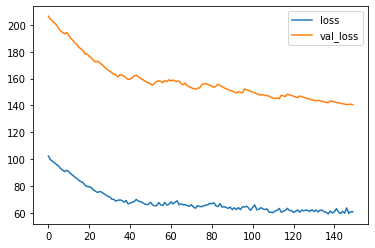

5/5 [==============================] - 0s 55ms/step - loss: 60.6518 - val_loss: 140.5874


In [7]:
def train_model(model, X_train, Y_train, validation, callbacks):

    model.fit(X_train, Y_train, epochs=150, batch_size=31, validation_data=validation, callbacks=callbacks)
    return model
  
model = train_model(get_model(), X_train, Y_train, (X_dev, Y_dev), [plot_losses])

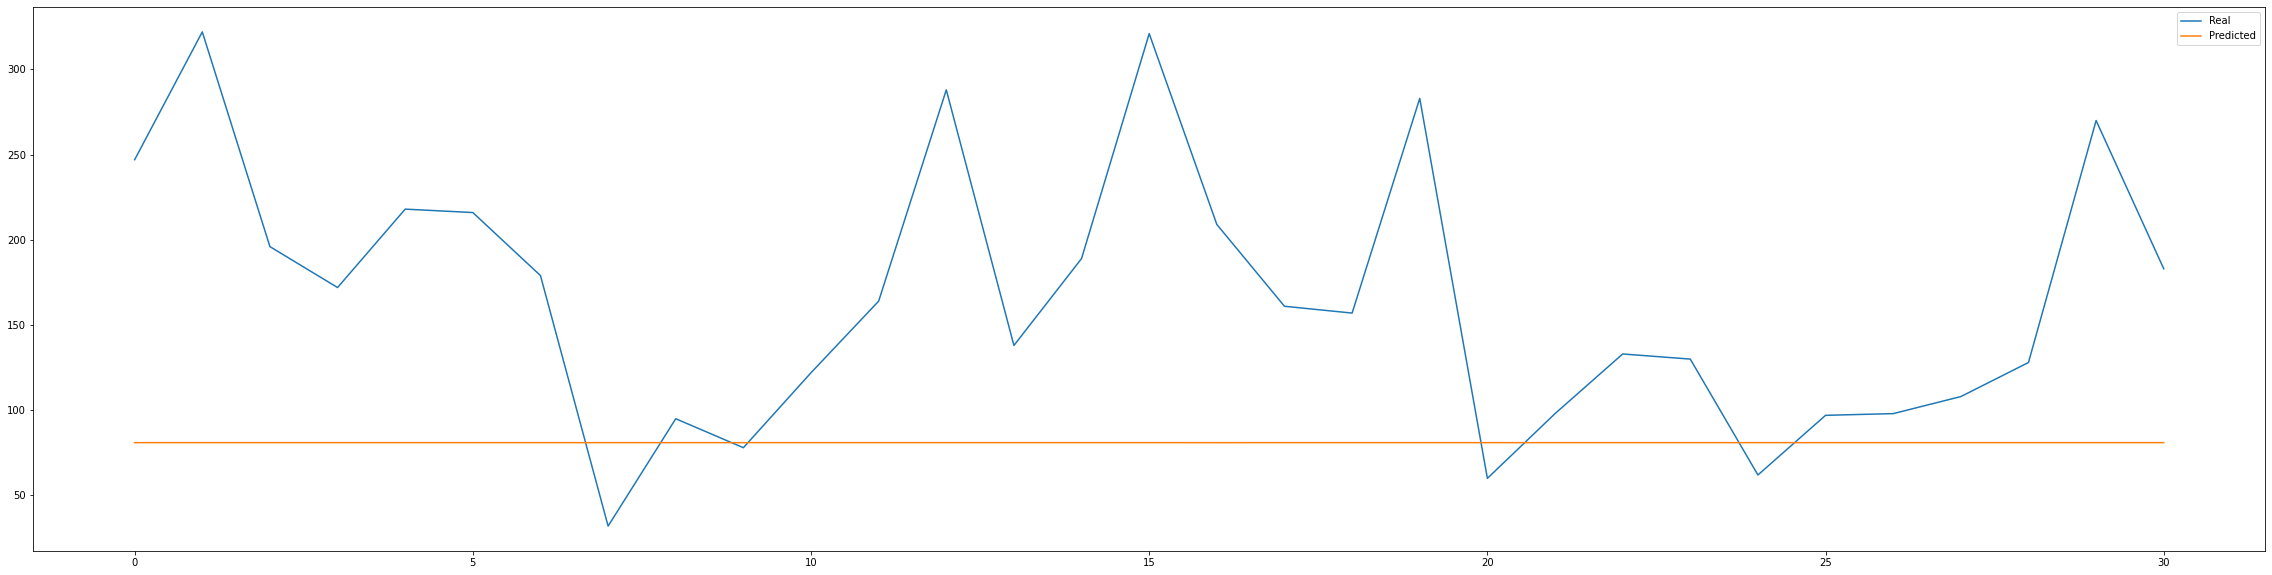

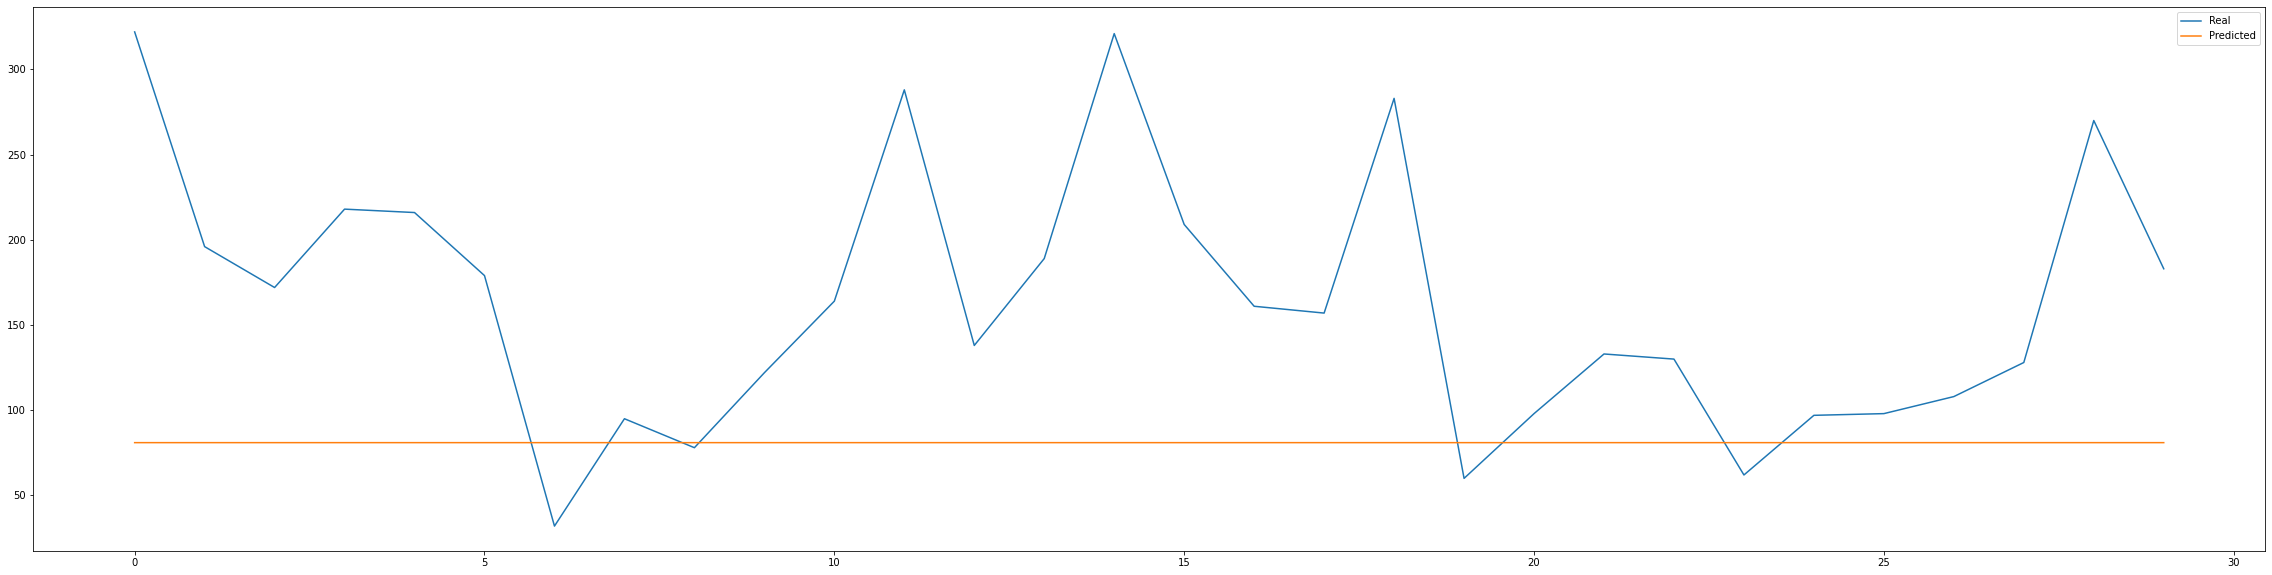

88.72311808268229

In [8]:
from sklearn.metrics import mean_absolute_error

def show_predict(model, X, Y):
    
    Y_predict = model.predict(X)
    
    plt.figure(figsize=(40,10))
    plt.plot(list(range(len(Y))), Y, label="Real")
    plt.plot(list(range(len(Y_predict))), Y_predict, label="Predicted")
    plt.legend()
    plt.show()

    return mean_absolute_error(Y, Y_predict)

show_predict(model, X_val[:31], Y_val[:31])
show_predict(model, X_val[1:31], Y_val[1:31])